# Elastic Solver

This code takes as an input a mesh, a set of points and the forces associated with said points, and based on a linear elasticity problem, it deforms the geometry basing itself on properties such as Young's modulus and Poisson's coefficient.

The approach made is using squared subdomains around each node, so that a different force is applied on every subdomain. This code, more efficient than the other approaches taken (Dirac Delta) only works when the mesh is structured, so that properties as symmetry are mantained.

In [ ]:
#Setup FeniCs, run on Colab

try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

In [3]:
pip install meshio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.7/167.7 kB 2.8 MB/s eta 0:00:00


In [17]:
import meshio
import matplotlib as plt

In [13]:
from mshr import *


In [ ]:
#Import the mesh that you would like to use
msh = meshio.read("meshDef.msh")
meshio.write("meshDef.xml",msh)
mesh = Mesh("meshDef.xml")


In [25]:
import numpy as np
from dolfin import *

#msh = meshio.read("meshdef2.xml")
#mesh = Mesh("meshdef2.xml")


#Example mesh, for explicative purposes
rect1 = Rectangle(Point(0,0), Point(1,5))
cir = Circle(Point(0.5, 0), 0.5)

domain = rect1 + cir
mesh = generate_mesh(domain, 250)

class boundary(SubDomain): #Define a subdomain of the mesh, only with the nodes where the following conditions are met
    def inside(self, x, on_boundary):
      if on_boundary:
        if  near(x[0], 0) or near(x[0], 1) or near(x[1] , 5): #Obtain the points on the boundary outside of the needle
          return False
        else:
          return True
      else:
        return False


V = FunctionSpace(mesh, "CG", 1)
mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary().mark(mf, 1) #Mark the elements of the desired boundary
v2d = vertex_to_dof_map(V)
dofs = []

for facet in facets(mesh):  #Obtain a list of the marked nodes
    if mf[facet.index()] == 1:
        vertices = facet.entities(0)
        for vertex in vertices:
            dofs.append(v2d[vertex])

unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
boundary_coords = V.tabulate_dof_coordinates()[unique_dofs]
np.sort(boundary_coords)
for i, dof in enumerate(unique_dofs):
    #print(boundary_coords[i])
    a=0

def sort_coordinates(coordinates, start_node):#Sorts the coordinates due to a point, due to the angle between a point and the centroid (the centroid of the needle works fine)
    # Find the centroid as the reference point
    centroid = np.mean(coordinates, axis=0)

    # Calculate the angles with respect to the centroid
    angles = np.arctan2(coordinates[:, 1] - centroid[1], coordinates[:, 0] - centroid[0])

    # Calculate angles with respect to the start node
    start_angle = np.arctan2(start_node[1] - centroid[1], start_node[0] - centroid[0])
    angles_relative = (angles - start_angle + 2 * np.pi) % (2 * np.pi)

    # Sort the coordinates based on angles
    sorted_indices = np.argsort(angles_relative)
    sorted_coordinates = coordinates[sorted_indices]

    return sorted_coordinates

sorted_coordinates = sort_coordinates(boundary_coords,[0.5,5])  #Obtain the coordinates of the mesh at the nodes where deformation will occur

"""
Note that if this solver is to be used after the electrostatic solver, there is no need for this step
to take place, as the list of points will already come from the electrostatic solver.
"""


'\nNote that if this solver is to be used after the electrostatic solver, there is no need for this step\nto take place, as the list of points will already come from the electrostatic solver.\n'

In [26]:
points  = sorted_coordinates

#Example usage, generate forces, when using the code, replace with actual forces obtained with the electrostatic solver
line1 = np.linspace(0, -18, num= round(len(sorted_coordinates)/2)-1)
line2 = np.linspace(-18, 0, num= round(len(sorted_coordinates)/2))

line = [j for i in [line1, [-18] , line2] for j in i]

line1x = np.linspace(-4, 0, num= round(len(sorted_coordinates)/2)-1)
line2x = np.linspace(0, 4, num= round(len(sorted_coordinates)/2))

linex = [j for i in [line1x, [0], line2x] for j in i]


#Fs = [[0, -9.81/len(points)]]*len(points)


Fs = []
for i in range(0, len(line)):
  Fs.append([linex[i], line[i]])




Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


Level 25:UFL_LEGACY:Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


Level 25:UFL_LEGACY:Notation dx[meshfunction] is deprecated. Please use dx(subdomain_data=meshfunction) instead.


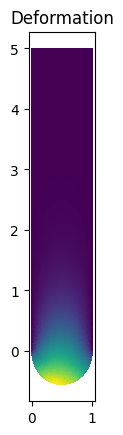

In [27]:

V = VectorFunctionSpace(mesh, 'Lagrange', degree=1)

def boundary(x, on_boundary):
    return on_boundary and (near(x[1], 5) or near(x[0],0) or near(x[0],1)   ) #Change with places where there will be no deformation. In this case, the needle


numSubdomains = len(points)

subdomains = [SubDomain() for _ in range(numSubdomains)] #Define one subdomain for every node where a force will be created.

# Define a list to store the markers for each subdomain
domain_markers = [MeshFunction("size_t", mesh, mesh.topology().dim(), 0) for _ in range(numSubdomains)]

forces = [Constant((Fs[i][0], Fs[i][1])) for i in range(numSubdomains)]  #Express the forces with the notation used by FeniCs

normalpoints = [] #Makes my points uniform to a unisquaremesh
for n in range(0, len(points)):
  normalpoints.append([points[n][0] , points[n][1] ])
boundary_points = normalpoints

# Size of the square around each point
square_size = 0.05 # Adjust as needed, depending on the separation of nodes.

# Create subdomains based on points
subdomains = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)

for i, point in enumerate(boundary_points, start=1): #Create the n subdomains in the form of squares
    subdomain_marker = AutoSubDomain(lambda x: between(x[0], (point[0] - square_size, point[0] + square_size)) and
                                              between(x[1], (point[1] - square_size, point[1] + square_size)))
    subdomain_marker.mark(subdomains, i)


dx = Measure("dx")[subdomains] #Create measure for the domain
ds = Measure("ds")[subdomains] #Create the measure for the boundary

#Deformations are calculated here
def eps(v):
    return sym(grad(v))

E = Constant(10) #Young's modulus: Measure of the stiffness of a material and is defined as the ratio of stress to strain in the elastic deformation range.
nu = Constant(0.3) # Poisson measure of the relative contraction or expansion of a material perpendicular to the direction of applied stress
model = "plane_stres"

mu = E/2/(1+nu) #Definition of Lamé's parameters
lmbda = E*nu/(1+nu)/(1-2*nu)

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

du = TrialFunction(V)
u_ = TestFunction(V)

a = inner(sigma(du), eps(u_))*dx #Define the variational form

l = 0

for i in range(0,len(Fs)):
  l = l + inner(forces[i], u_)*dx(i+1) #Add every force, one by one, integrating only on the needed subdomain

bc = DirichletBC(V, Constant((0.,0.)), boundary) #Boundary condition for needle (no deformation on that way)

u = Function(V, name="Displacement")
solve(a == l, u, bc) #Solve the elastic problem

plot(u, mode="displacement", title = "Deformation")


In [20]:
file = File("Deforma.pvd") #Save deformations for visualization in Paraview
file << u

In [21]:
def update_mesh(mesh, displacement): #Create a new mesh, with the geometry of the displacements.
    new_mesh = Mesh(mesh)
    ALE.move(new_mesh, displacement)
    return new_mesh

mesh = update_mesh(mesh,u)
mesh_file = File("meshdef2.xml") #Save the mesh as an xml file
mesh_file << mesh

In [ ]:
import math
from dolfin import *

msh = meshio.read("meshdef2.xml")
meshio.write("meshdef2.xml",msh)
mesh = Mesh("meshdef2.xml")

class boundary(SubDomain): #Take the boundary points of the new, deformed mesh. This will be useful for greating a .Geo() geometry
    def inside(self, x, on_boundary):
      if on_boundary:
        if near(x[1], 5): #Take the top  part of the boundary, we don't need these nodes
          return False
        else:
          return True

V = FunctionSpace(mesh, "CG", 1)
v = project(Expression("x[0]+x[1]", degree=2),V)
mf = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
boundary().mark(mf, 1)
v2d = vertex_to_dof_map(V)
dofs = []
for facet in facets(mesh):
    if mf[facet.index()] == 1:
        vertices = facet.entities(0)
        for vertex in vertices:
                dofs.append(v2d[vertex])
unique_dofs = np.array(list(set(dofs)), dtype=np.int32)
boundary_coords1 = V.tabulate_dof_coordinates()[unique_dofs]


boundary_coords_aux = [0]*len(boundary_coords1)

def angle_with_reference(point, reference_point):
      x, y = point[0] - reference_point[0], point[1] - reference_point[1]
      return math.atan2(y, x)

def sort_counterclockwise(points):
      # Find the centroid as the reference point
      reference_point = [sum(x[0] for x in points) / len(points), sum(x[1] for x in points) / len(points)]

      # Sort points based on the angle with the reference point
      sorted_points = sorted(points, key=lambda point: angle_with_reference(point, reference_point))

      return sorted_points

boundary_coords = sort_counterclockwise(boundary_coords1)

mesh_cords = [0]*len(boundary_coords)
for i in range(0, len(boundary_coords)):
  mesh_cords[i] = Point(boundary_coords[i][0],boundary_coords[i][1])



Attempt to write .geo() from zero

In [23]:
#With the nodes obtained from the boundary, create a .geo geometry, so that a new mesh, to iterate the electrostatic solver on it can be created.

#The mesh gives the needle part of the boundary, the rest must be done manually.

with open('Iteration.txt', 'w') as file:
    # Write content to the file
    for i in range(0, len(mesh_cords)-1):
      file.write("//+ \n")
      file.write("Point("+str(i+1) +") = {" + str(mesh_cords[i][0]) + "," + str(mesh_cords[i][1]) + ",0,1}; \n")

    file.write("//+//+ \n")

    for i in range(1, len(mesh_cords)-1):
      file.write("//+ \n")
      file.write("Line(" + str(i) + ") = {" + str(i) +", " + str(i+1)+"}; \n")
    file.write("Line(" + str(len(mesh_cords)-1) + ") = { 1 ," + str(len(mesh_cords)-1) + "}; \n" )

